## This notebook is a second model that builds on the first model. More features. Picked XGBoost as it performed the best

In [1]:
import pickle
import pandas as pd
import numpy as np

In [2]:
file = open('../Cleanup/cv_df_extracted', 'rb')
cv_df = pickle.load(file)

In [3]:
# Extract columns to be pushed into model
prog_df = cv_df[['CLNSIG','AF_ESP','AF_EXAC','AF_TGP','CADD_RAW','BLOSUM62']]

In [4]:
# Clean and fill in missing values. BLOSUM62 missing values automatically mean 0. 
prog_df.loc[prog_df['BLOSUM62'] == '', ['BLOSUM62']] = '0'
prog_df.loc[prog_df['CADD_RAW'] == '', ['CADD_RAW']] = '0'
prog_df.loc[prog_df['AF_ESP'] == '', ['AF_ESP']] = '0'
prog_df.loc[prog_df['AF_EXAC'] == '', ['AF_EXAC']] = '0'
prog_df.loc[prog_df['AF_TGP'] == '', ['AF_TGP']] = '0'

prog_df['AF_ESP'].fillna(0, inplace=True)
prog_df['AF_EXAC'].fillna(0, inplace=True)
prog_df['AF_TGP'].fillna(0, inplace=True)


In [5]:
# Cast types of columns as something XGBoost will be happy with
prog_df = prog_df.astype({'CADD_RAW': 'float', 'BLOSUM62': 'int64','AF_ESP': 'float','AF_EXAC': 'float','AF_TGP': 'float'})

## FINALLY MODELLING!

In [6]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

import matplotlib.pyplot as plt


In [7]:
X = prog_df[['AF_ESP','AF_EXAC','AF_TGP','CADD_RAW','BLOSUM62']]
y = prog_df['CLNSIG']

X_traintest, X_hold, y_traintest, y_hold = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size = 0.2, random_state = 42)

xg_clas = xgb.XGBClassifier()

In [8]:
X.dtypes

AF_ESP      float64
AF_EXAC     float64
AF_TGP      float64
CADD_RAW    float64
BLOSUM62      int64
dtype: object

In [9]:
xg_clas.fit(X_train, y_train)
xg_clas.score(X_test,y_test)

0.8400173422935183

Text(33.0, 0.5, 'Actual')

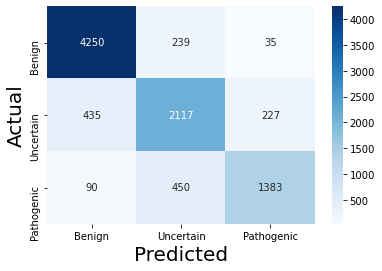

In [10]:
from sklearn.metrics import confusion_matrix
#Generate predictions with the model using our X values
y_pred = xg_clas.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
#Swap rows 2,3 and columns 2,3, for better understanding
cf_matrix[[1,2]] = cf_matrix[[2,1]]
cf_matrix[:, [1, 2]] = cf_matrix[:, [2, 1]]
cf_df = pd.DataFrame(cf_matrix)

cf_df.rename(columns={0: "Benign", 1: "Uncertain", 2: "Pathogenic"}, inplace=True)
cf_df.rename(index={0: "Benign", 1: "Uncertain", 2: "Pathogenic"})

import seaborn as sns
columns = ['Benign','Uncertain','Pathogenic']
ax = sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels = columns, yticklabels = columns)
plt.xlabel("Predicted", fontsize = 20)
plt.ylabel("Actual", fontsize = 20)

### Below are attempts to see what is so different about the data in squares in the top right or bottom left....

In [11]:

pred_actu = list(zip(y_test.index,xg_clas.predict(X_test),y_test))
pred_actu = pd.DataFrame(pred_actu, columns=['indices','predicted','actual'])
pred_actu = pred_actu.set_index('indices').sort_values('indices')


pred_bad_but_benign = pred_actu[(pred_actu['predicted'] == 'Pathogenic_cat') & (pred_actu['actual'] == 'Benign_cat')].index
pred_benign_but_bad = pred_actu[(pred_actu['predicted'] == 'Benign_cat') & (pred_actu['actual'] == 'Pathogenic_cat')].index

In [12]:
good = X_test.loc[pred_bad_but_benign].head(50)
good.describe()

,AF_ESP,AF_EXAC,AF_TGP,CADD_RAW,BLOSUM62
count,35.000000,35.000000,35.0,35.000000,35.000000
mean,0.000466,0.000003,0.0,2.897935,-0.200000
std,0.002276,0.000020,0.0,2.276917,0.719477
min,0.000000,0.000000,0.0,0.000000,-3.000000
25%,0.000000,0.000000,0.0,2.439259,0.000000
50%,0.000000,0.000000,0.0,2.545188,0.000000
75%,0.000000,0.000000,0.0,3.747518,0.000000
max,0.013400,0.000120,0.0,9.652219,0.000000


In [13]:
bad = X_test.loc[pred_benign_but_bad]
bad.describe()

,AF_ESP,AF_EXAC,AF_TGP,CADD_RAW,BLOSUM62
count,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.000597,0.005813,0.000338,2.041722,-0.033333
std,0.001900,0.050052,0.000978,1.720709,0.694278
min,0.000000,0.000000,0.000000,-2.329564,-3.000000
25%,0.000000,0.000000,0.000000,1.268945,0.000000
50%,0.000000,0.000000,0.000000,1.850506,0.000000
75%,0.000000,0.000100,0.000000,2.284084,0.000000
max,0.013900,0.475110,0.006000,7.561957,3.000000
